In [ ]:
#!pip install tensorflow-text

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
#!pip install tensorflow-text
import tensorflow_text as text

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [ ]:
# takes list of predictions and labels
def evaluation(class_labels, predictions):
    labels = [0,1] 
    print(accuracy_score(class_labels, predictions))
    print(classification_report(class_labels, predictions, labels=labels)) #classification report from sklearn
    cnf_matrix = confusion_matrix(class_labels, predictions, labels=labels)
    plt.imshow(cnf_matrix, cmap=plt.cm.Blues) #plot confusion matrix grid
    threshold = cnf_matrix.max() / 2 #threshold to define text color
    for i in range(cnf_matrix.shape[0]): #print text in grid
        for j in range(cnf_matrix.shape[1]): 
            plt.text(j, i, cnf_matrix[i,j], color="w" if cnf_matrix[i,j] > threshold else 'black')
    tick_marks = np.arange(len(labels)) #define labeling spacing based on number of classes
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.colorbar()
    plt.tight_layout()

In [ ]:
import pandas as pd

data = pd.read_excel (r'data.xlsx') 
df = pd.DataFrame(data)
df.head()

,Unnamed: 0,CASE,Q4 ANSWER,Q4 Score,Q9 ANSWER,Q9 Score,Score 1-4 Q4,Ashray Score,Score 1-4 Q9,Ashray Score.1
0,NaN,Case 2a,"Yes, offering the discounts will help increase...",44,"In a normal scenario, the client would pay 100...",44,2,NaN,2.0,2.0
1,NaN,Case 2a,It depends. If they want to promote the use of...,33,If for every $10 increase the possibility of a...,78,2,NaN,4.0,2.0
2,NaN,Case 2a,the introduction is very profitable from Vivit...,0,the increase in premiums corresponds to an inc...,33,1,NaN,2.0,4.0
3,NaN,Case 2a,"To decide whether this is a good idea, I would...",0,The expected cost increase by 150$ per opt-out...,44,1,NaN,2.0,1.0
4,NaN,Case 2a,Ich würde empfehlen das Angebot auch den beste...,6,`-,0,1,NaN,1.0,1.0


In [ ]:
q4_df = df[["Q4 ANSWER","Q4 Score","Score 1-4 Q4"]]
q4_df.head()

q9_df = df[["Q9 ANSWER","Q9 Score","Score 1-4 Q9"]]
q9_df.head()

q4_df = q4_df.rename(columns = {"Q4 ANSWER":"answer","Q4 Score":"score_100","Score 1-4 Q4":"score_4"})
q9_df = q9_df.rename(columns = {"Q9 ANSWER":"answer","Q9 Score":"score_100","Score 1-4 Q9":"score_4"})

q4_df = q4_df[q4_df.answer != "`-"]
q9_df = q9_df[q9_df.answer != "`-"]

In [ ]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from nltk.stem.snowball import SnowballStemmer
st = SnowballStemmer('english')

# function to clean data
def clean_data(df, col, clean_col):

    # change to lower and remove spaces on either side
    df[clean_col] = df[col].apply(lambda x: x.lower().strip())

    # remove extra spaces in between
    df[clean_col] = df[clean_col].apply(lambda x: re.sub(' +', ' ', x))

    # remove punctuation
    df[clean_col] = df[clean_col].apply(lambda x: re.sub('[^a-zA-Z]', ' ', x))

    # remove stopwords and get the stem
    df[clean_col] = df[clean_col].apply(lambda x: ' '.join(st.stem(text) for text in x.split() if text not in stop_words))

    return df

def normalize(df, col):
  # min-max feature scaling
  df[col] = (df[col] - df[col].min()) / (df[col].max() - df[col].min())
  return df

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
q4_df = clean_data(q4_df, 'answer', 'answer')
q9_df = clean_data(q9_df, 'answer', 'answer')

# q4_df = normalize(q4_df,'score_4')
q4_df = normalize(q4_df,'score_100')
# q9_df = normalize(q9_df,'score_4')
q9_df = normalize(q9_df,'score_100')

In [ ]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [ ]:
#q4_df['score_4'] = q4_df['score_4'].apply(lambda x: 0 if x in [0,1] else 1)
#q4_df.head()

q4_df['label'] = q4_df['score_100'].apply(lambda x: 0 if x<.5 else 1)
q4_df.head()

,answer,score_100,score_4,label
0,yes offer discount help increas predict need p...,0.44,2,0
1,depend want promot use fit tracker could offer...,0.33,2,0
2,introduct profit vivita side consum point view...,0.00,1,0
3,decid whether good idea would like understand ...,0.00,1,0
4,ich w rde empfehlen das angebot auch den beste...,0.06,1,0


In [ ]:
q9_df['label'] = q9_df['score_100'].apply(lambda x: 0 if x<.5 else 1)
q9_df.head()

,answer,score_100,score_4,label
0,normal scenario client would pay would die rec...,0.44,2.0,0
1,everi increas possibl claim increas eventu cos...,0.78,4.0,1
2,increas premium correspond increas meanwhil in...,0.33,2.0,0
3,expect cost increas per opt wherea revenu increas,0.44,2.0,0
6,probabl claim increas possibl cost also increa...,0.67,3.0,1


In [ ]:
from sklearn.model_selection import train_test_split

def train(texts,labels):
  X_train, X_test, y_train, y_test = train_test_split(texts,labels, test_size = .25, stratify=labels)
  X_train.head(4)

  # Bert layers
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessed_text = bert_preprocess(text_input)
  outputs = bert_encoder(preprocessed_text)

  # Neural network layers
  l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
  l = tf.keras.layers.Dense(64, activation='relu', name="train")(l)
  l = tf.keras.layers.Dense(1, activation="sigmoid", name="output")(l)
  # Use inputs and outputs to construct a final model
  model = tf.keras.Model(inputs=[text_input], outputs = [l])

  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  model.fit(X_train, y_train, epochs=25, batch_size = 32)

  y_predicted = model.predict(X_test)
  y_predicted = [1 if x>=0.5 else 0 for x in y_predicted.flatten()]

  evaluation(y_test,y_predicted)

  return model

Training for question 4

Epoch 1/25
8/8 [==============================] - 109s 13s/step - loss: 0.8327 - accuracy: 0.4513
Epoch 2/25
8/8 [==============================] - 107s 13s/step - loss: 0.6847 - accuracy: 0.5885
Epoch 3/25
8/8 [==============================] - 105s 13s/step - loss: 0.7260 - accuracy: 0.5044
Epoch 4/25
8/8 [==============================] - 105s 13s/step - loss: 0.6937 - accuracy: 0.5177
Epoch 5/25
8/8 [==============================] - 105s 13s/step - loss: 0.6831 - accuracy: 0.5531
Epoch 6/25
8/8 [==============================] - 107s 13s/step - loss: 0.6792 - accuracy: 0.5664
Epoch 7/25
8/8 [==============================] - 106s 13s/step - loss: 0.6915 - accuracy: 0.5619
Epoch 8/25
8/8 [==============================] - 105s 13s/step - loss: 0.6753 - accuracy: 0.5442
Epoch 9/25
8/8 [==============================] - 105s 13s/step - loss: 0.6871 - accuracy: 0.5885
Epoch 10/25
8/8 [==============================] - 104s 13s/step - loss: 0.6787 - accuracy: 0.5531
Epoch 11/25
8/8 [==

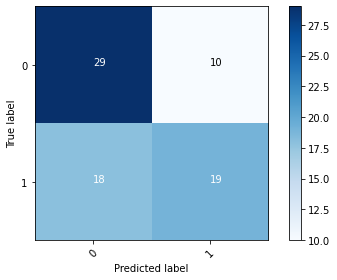

In [ ]:
model= train(q4_df['answer'],q4_df['label'])

Evaluation for question 9

Epoch 1/25
5/5 [==============================] - 71s 13s/step - loss: 0.7144 - accuracy: 0.5442
Epoch 2/25
5/5 [==============================] - 68s 13s/step - loss: 0.7168 - accuracy: 0.5442
Epoch 3/25
5/5 [==============================] - 68s 13s/step - loss: 0.6896 - accuracy: 0.5510
Epoch 4/25
5/5 [==============================] - 66s 13s/step - loss: 0.6708 - accuracy: 0.6259
Epoch 5/25
5/5 [==============================] - 68s 13s/step - loss: 0.6736 - accuracy: 0.5646
Epoch 6/25
5/5 [==============================] - 68s 13s/step - loss: 0.6790 - accuracy: 0.5918
Epoch 7/25
5/5 [==============================] - 69s 13s/step - loss: 0.6375 - accuracy: 0.6531
Epoch 8/25
5/5 [==============================] - 69s 14s/step - loss: 0.6385 - accuracy: 0.6395
Epoch 9/25
5/5 [==============================] - 67s 13s/step - loss: 0.6420 - accuracy: 0.6463
Epoch 10/25
5/5 [==============================] - 69s 13s/step - loss: 0.6457 - accuracy: 0.6190
Epoch 11/25
5/5 [============

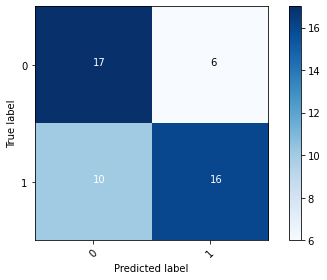

In [ ]:
model = train(q9_df['answer'],q9_df['label'])